# Face recognition using Siamese networks

We use Siamese network to build face recognition model. The objective of the network is to understand whether two faces are similar or dissimilar. We use the AT&T Database of Faces, which can be downloaded from here: https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html.

In [1]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


Once downloaded and extracted the archive, we see the folders s1, s2, up to s40. Each of these folders has 10 different images of a single person taken from various angles.

So, we will take two images randomly from the same folder and mark them as a genuine pair and we will take single images from two different folders and mark them as an imposite pair.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

read_image function takes as input an image and returns a NumPy array

In [2]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

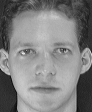

In [3]:
Image.open("att_faces/s1/1.pgm")

In [4]:
img = read_image('att_faces/s1/1.pgm')
img.shape

(112, 92)

In [69]:
size = 2
total_sample_size = 10000

we concatenate both x_genuine_pair and x_imposite to X and y_genuine and y_imposite to Y

In [ ]:
def get_data(size, total_sample_size):
    #read the image
    image = read_image('att_faces/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2]) # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('att_faces/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('att_faces/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('att_faces/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('att_faces/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

We generate our data and check our data size. As you can see, we have 20,000 data points and, out of these, 10,000 are genuine pairs and 10,000 are imposite pairs:

In [ ]:
X, Y = get_data(size, total_sample_size)

We split our data for training and testing with 75% training and 25% testing proportions

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.75)

We build our siamese network. First, we define the base network, which is basically a convolutional network used for feature extraction. We build two convolutional layers with ReLU activations and max pooling followed by a flat layer

In [8]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

We feed the image pair to the base network, which will return the embeddings, that is, feature vectors

In [9]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

W0715 11:02:25.505349 140449097320256 deprecation_wrapper.py:119] From /home/aiscientist/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 11:02:25.532749 140449097320256 deprecation_wrapper.py:119] From /home/aiscientist/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/home/aiscientist/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), input_shape=(1, 56, 46..., padding="valid", data_format="channels_first")`
  # This is added back by InteractiveShellApp.init_path()
W0715 11:02:25.543083 140449097320256 deprecation_wrapper.py:119] From /home/aiscientist/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_un

In [10]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

In [11]:
epochs = 5
rms = RMSprop()

model = Model(input=[img_a, img_b], output=distance)

/home/aiscientist/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  after removing the cwd from sys.path.


In [12]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

model.compile(loss=contrastive_loss, optimizer=rms)

W0715 11:02:42.751529 140449097320256 deprecation_wrapper.py:119] From /home/aiscientist/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [13]:
img_1 = x_train[:, 0]
img_2 = x_train[:, 1] 

model.fit([img_1, img_2], y_train, validation_split=.25, batch_size=128, verbose=2, nb_epoch=epochs)

/home/aiscientist/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.
W0715 11:02:45.211927 140449097320256 deprecation.py:323] From /home/aiscientist/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 3750 samples, validate on 1250 samples
Epoch 1/5
 - 14s - loss: 0.2559 - val_loss: 0.3482
Epoch 2/5
 - 11s - loss: 0.1801 - val_loss: 0.3007
Epoch 3/5
 - 11s - loss: 0.1391 - val_loss: 0.2985
Epoch 4/5
 - 11s - loss: 0.1184 - val_loss: 0.2764
Epoch 5/5
 - 11s - loss: 0.1078 - val_loss: 0.2850


In [40]:
threshold = 40

In [59]:
def predict_score(image1, image2, threshold):
    '''Predict distance score and classify test images as Same or Different'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(image1), cmap='gray')
    ax2.imshow(np.squeeze(image2), cmap='gray')
    image11 = image1[::size, ::size]
    image21 = image2[::size, ::size]
    x_validate = np.zeros([2, 2, 1, 56, 46])
    x_validate[1, 0, 0, :, :] = image11
    x_validate[1, 1, 0, :, :] = image21
    predScore = model.predict([x_validate[:, 0], x_validate[:, 1]])
    predScore = predScore[1][0]
    test_label = 0
    if(predScore < threshold):
        test_label = 1
    ax1.set_title('Existing Photo')
    if test_label == 1:
        ax2.set_title('New Photo')
    else:
        ax2.set_title('New Photo')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    print("Difference Score = ", predScore)
    if predScore < threshold:
        print("Both photos belong to same person")
    else:
        print("Photos belong to different people")

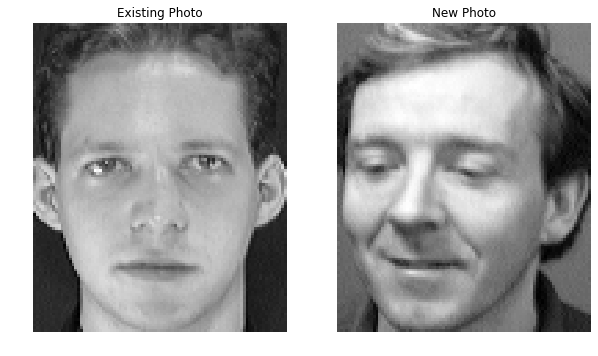

Difference Score =  66.96915
Photos belong to different people


In [68]:
image1 = read_image('att_faces/s1/1.pgm')
image2 = read_image('att_faces/s3/5.pgm')
predict_score(image1, image2, threshold)